In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import xgboost as xgb
import shap

# helper functions provided in helper_functions.py
from helper_functions import remove_sac_events, get_kde_dist_plots
#pip install ipynb

shap.initjs()

In [2]:
# train is the first half of season batted ball data, processed in the 01-EDA&PreProcessing notebook
train = pd.read_csv('../data/processed/processed_first_half_batted_balls.csv')
# test is the second half season SLG% for each player-season
test = pd.read_csv('../data/raw/second_half_slg.csv')

In [3]:
# pre-processed dataset ready for modeling
train

,pitch_release_speed,pitch_spin_rate,pitch_spin_axis,pitch_release_height,pitch_release_side,pitch_extension,pitch_vert_break,pitch_induced_vert_break,pitch_horz_break,pitch_plate_height,pitch_plate_side,hit_exit_speed,hit_vert_exit_angle,hit_horz_exit_angle,hit_spin_rate,hit_distance,slg,bat_side_L,bat_side_R,pitch_side_L,pitch_side_R,pre_balls_0,pre_balls_1,pre_balls_2,pre_balls_3,pre_strikes_0,pre_strikes_1,pre_strikes_2,pre_outs_0,pre_outs_1,pre_outs_2,pitch_type_ChangeUp,pitch_type_Changeup,pitch_type_Curveball,pitch_type_Cutter,pitch_type_Fastball,pitch_type_Four-Seam,pitch_type_KnuckleBall,pitch_type_Other,pitch_type_Sinker,pitch_type_Slider,pitch_type_Splitter,pitch_type_Undefined,pitch_type_nan,event_type_double,event_type_double_play,event_type_field_error,event_type_field_out,event_type_fielders_choice,event_type_fielders_choice_out,event_type_force_out,event_type_grounded_into_double_play,event_type_home_run,event_type_single,event_type_triple,event_type_triple_play,batter_id,pitcher_id,season
0,95.520002,2195.511800,197.567006,6.076918,1.131171,5.509253,-14.508357,17.015614,4.866302,2.995102,-0.624306,67.386173,-13.940554,-3.331062,2570.292297,12.3166,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,x1a144c53,x5a365c39,2017
1,86.608715,2209.950094,88.530611,4.598388,-3.290455,5.827094,-36.348362,1.274052,-19.603756,2.059211,-0.866770,86.749105,-7.099422,-25.003463,4834.065214,13.8123,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,xbed99798,x74a5c086,2017
2,82.602484,2347.988740,152.853349,6.079954,1.993246,5.784996,-32.741526,8.329462,-3.341363,2.658454,0.151087,97.727244,30.130697,-1.464437,2676.402803,367.1120,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,x1a144c53,x607b9354,2017
3,94.551664,2122.917873,240.983269,6.084905,2.483645,5.427153,-22.130647,9.660908,14.986313,2.421182,-0.224985,103.634872,3.777952,-8.210238,959.542630,99.5115,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,x3c899258,xd7aff4b8,2017
4,80.836145,2486.799467,180.682600,6.077955,-2.337797,5.600363,-31.738645,11.244203,0.112744,2.451857,-0.607118,92.305361,25.288136,16.995705,2467.164262,364.5160,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,xbed99798,x7cf545bd,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59359,87.999753,2044.014507,164.020086,6.353934,-1.467392,7.052112,-14.701534,19.366584,-5.555105,2.665267,-0.120858,99.071271,29.249762,-4.432223,2970.740444,395.7940,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,x25b65d9d,xd55aca85,2019
59360,87.999753,2044.014507,164.020086,6.353934,-1.467392,7.052112,-14.701534,19.366584,-5.555105,2.665267,-0.120858,99.071271,29.249762,-4.432223,2970.740444,395.7940,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,x25b65d9d,xd55aca85,2019
59361,92.598658,2214.592447,197.503816,5.966697,1.744260,6.563445,-14.221122,17.448810,4.823077,3.009990,-0.991368,57.756110,57.541242,-29.627913,3651.971042,152.5200,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59364 entries, 0 to 59363
Data columns (total 59 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   pitch_release_speed                   59364 non-null  float64
 1   pitch_spin_rate                       59364 non-null  float64
 2   pitch_spin_axis                       59364 non-null  float64
 3   pitch_release_height                  59364 non-null  float64
 4   pitch_release_side                    59364 non-null  float64
 5   pitch_extension                       59364 non-null  float64
 6   pitch_vert_break                      59364 non-null  float64
 7   pitch_induced_vert_break              59364 non-null  float64
 8   pitch_horz_break                      59364 non-null  float64
 9   pitch_plate_height                    59364 non-null  float64
 10  pitch_plate_side                      59364 non-null  float64
 11  hit_exit_speed 

# **Modeling Approach**

I chose to use 2 ensemble models to capture the relationships in the batted ball data fro predicting SLG. I will use the best performing model in terms of R-squared and root mean squared error (RMSE) to estimate 1H Expected Slugging (xSLG), and then incorporate the xSLG metric into a stacked regression model, regressed to predict 2nd half slugging.

**Random Forest Regression (Bagging)**: A bagging model, 

**XGBoost Regression (Boosting)**: A boosting model, 

**Tuning**: Used GridSearchCV to tune both models, iterating over hyperparameters such as learning rate, number of estimators, etc.

**Model Evaluation**: Used RMSE on test data and R-squared as primary metrics for evaluation. 

**Model Interpretation**: Using Shapley values, identified the most significant features for predicting SLG.

-----

Step 1. Split 1H batted ball data into 80% for training the model, 20% held out for testing and evaluating model performance

Step 2. Train RF and XGBoost models on training data, evaluate against held out testing data using 4-fold cross validation.

Step 3. Tune model hyperparameters using GridSearchCV to achieve the optimal accuracy and R-squared

Step 4. Interpret both models, identify significant features

In [5]:
# need to drop event_types, slg
event_cols = ['event_type_double', 'event_type_double_play', 'event_type_field_error', 'event_type_field_out',
'event_type_fielders_choice', 'event_type_fielders_choice_out', 'event_type_force_out',
'event_type_grounded_into_double_play', 'event_type_home_run','event_type_single', 'event_type_triple', 'event_type_triple_play']

X = train.drop(columns=['slg', 'batter_id', 'pitcher_id'])
X = X.drop(columns=event_cols)
y = train['slg'].values.ravel()

# split training data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

## **Random Forest Regression Model**

Takes ~3 mins to train and cross-validate model

In [6]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE (Random Forest):", mse)
r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")
cv_score = cross_val_score(rfr, X_test, y_test, cv=4)
print('CV Mean Score: ', cv_score.mean())

RMSE (Random Forest): 0.6064664179035865
R^2: 0.6312592301295301
CV Mean Score:  0.5954640763531462


### **Random Forest Tuning**

Below is code to tune the Random Forest Regression model, because it can take alot of time to run the GridSearchCV function, I commented it out and directly provided the optimal paramters. If you would like to run the GridSearchCV yourself feel free, just expect it to take a bit of time (>1.5 hrs).

Best parameters (Random Forest): {'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 100}


In [7]:
params_rf = {
    'n_estimators': [60, 80, 100],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [6, 8, 10]
}

rf = RandomForestRegressor(random_state=1)
clf_rf = GridSearchCV(estimator=rf, 
                      param_grid=params_rf,
                      scoring='neg_mean_squared_error', 
                      verbose=1)

### uncomment the lines below to run GridSearchCV
#clf_rf.fit(X_train, y_train)

#print("Best parameters (Random Forest):", clf_rf.best_params_)
#print("Lowest RMSE (Random Forest):", (-clf_rf.best_score_)**(1/2.0))

The Random Forest model has slightly improved in RMSE and R^2

In [8]:
# optimal params from gridsearchcv
params_rf = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 8
}

# RandomForestRegressor with tuned parameters
rfr_model = RandomForestRegressor(random_state=1, **params_rf)

# fit model to training data
rfr_model.fit(X_train, y_train)

# predictions on held out test data
y_pred = rfr_model.predict(X_test)

# evaluating model performance
mse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE (Random Forest):", mse)
r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")
cv_score = cross_val_score(rfr_model, X_test, y_test, cv=4)
print('CV Mean Score: ', cv_score.mean())

RMSE (Random Forest): 0.6013226969393826
R^2: 0.6374876252429313
CV Mean Score:  0.5993503548654752


## **XGBoost Model**

In [9]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=1)

xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE (Random Forest):", mse)
r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")
cv_score = cross_val_score(xgbr, X_test, y_test, cv=4)
print('CV Mean Score: ', cv_score.mean())

RMSE (Random Forest): 0.613304812935262
R^2: 0.6228966515049099
CV Mean Score:  0.5682360188760861


### **XGBoost Tuning**

Below are the parameters I was able to get the lowest RMSE with. I commented out the GridSearchCV function because it can take alot of time to run, but you can uncomment and run if you like.

Best parameters: {'colsample_bytree': 0.75, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 600} 


In [10]:
params={ 'max_depth': [6, 9, 12],
         'colsample_bytree':[.6, 0.75, .8],
         'learning_rate':[0.001, 0.01, .02],
         'n_estimators': [300, 600, 900]}

xgbr = xgb.XGBRegressor(seed = 1)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
### uncomment the lines below to run GridSearchCV
#clf.fit(X_train, y_train)

#print("Best parameters:", clf.best_params_)
#print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [11]:
params_xgb = { 'objective':'reg:squarederror',
         'max_depth': 9, 
         'colsample_bytree': 0.75,
         'learning_rate': 0.01,
         'n_estimators': 600,
         'random_state' : 1}

xgbr_model = xgb.XGBRegressor(seed = 1, **params_xgb)
xgbr_model.fit(X_train, y_train)

# make predictions on the test set
y_pred = xgbr_model.predict(X_test)

# evaluate model performance
mse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE (XGBoost):", mse)
r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")
cv_score = cross_val_score(xgbr_model, X_test, y_test, cv=4)
print('CV Mean Score: ', cv_score.mean())

RMSE (XGBoost): 0.5927172063696261
R^2: 0.6477891643768455
CV Mean Score:  0.6081044515208168


## **xSLG Model Results & Intepretation**

### **Evaluating xSLG Model Performance**

After fitting and tuning both models, we found that the XGBoost model performs slightly better in terms of MSE and has a higher R-squared (better at explaining variance in predicting SLG). The comparison between the 2 tuned models is shown below

**Random Forest**
- MSE: .6013
- R^2: .6374

**XGBoost**
- MSE: .5927
- R^2: .6477

We will go forward with using the XGBoost model to estimate xSLG, and incorporate the 1H xSLG projections into the stacked model to predict 2H SLG. Below, I show how we can interpret the model to identify the most significant features and values for predicting SLG using shapley values.

### **Shap(ley) Values Model Intepretation**

Key conclusions from our SHAP explainer chart below:
* hit_distance, hit_horz_exit_angle, hit_exit_speed and hit_vert_exit_angle are the most significant features from our XGBoost Regression model for predicting SLG.

* The horizontal and vertical exit angles are interesting because we see a positive cluster in the vertical exit angle and a negative cluster in the horizontal exit angle data points. 
    - This makes sense, balls hit to the pull-side will generally yield more XBH, while the same can be said for balls hit in the air compared to balls hit into the ground.

The explainer chart results make sense, the further and faster the ball is hit, the more likely that powerful contact was made resulting in a ball hit to the deepest parts of the ballpark, and in some cases, home runs.

[15:37:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


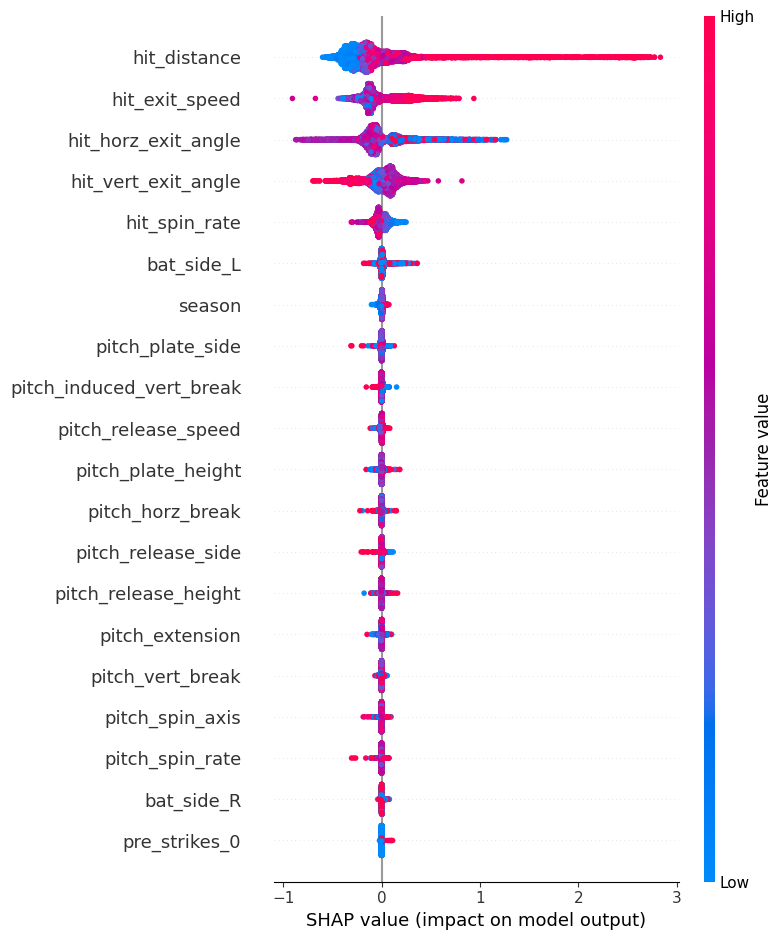

In [12]:
# xgb shap
explainer = shap.TreeExplainer(xgbr_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

The SHAP explainer chart seems to show there is a "sweet spot" for hit_spin_rate to maximize hit_distance. We explore the relationship between these two variables below, and see that there is a range from 1000-4000 spin rate that produces the highest rates of hit_distance. Below and above this range, we see hit_distance decrease. 

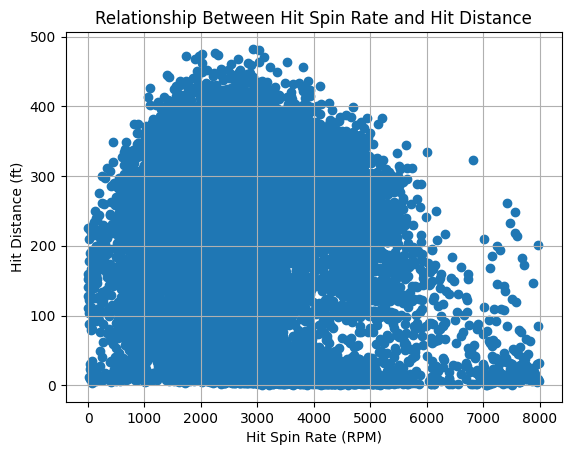

In [13]:
plt.scatter(X_test['hit_spin_rate'], X_test['hit_distance'])
plt.xlabel("Hit Spin Rate (RPM)")
plt.ylabel("Hit Distance (ft)")
plt.title("Relationship Between Hit Spin Rate and Hit Distance")
plt.grid(True)
plt.show()

We can visualize how features are contributing to each individual xSLG projection by calling the force_plot method (shown below). 

In [14]:
shap.initjs()
# 0 idx is 3 ft hit dist
# 1 idx is 362 ft hit dist
idx = 1

shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    X_test.iloc[idx,:],
)

In [15]:
### uncomment line below to investigate individual data points
#X_test.iloc[0:20,:]

Note: I provided code to run the Random Forest model shap values interpreter, but commented it out since it takes ~6 mins to run. Feel free to uncomment and run, but the results are almost identical to the XGBoost shap interpreter. 

In [16]:
### random forest shap
#explainer = shap.TreeExplainer(rfr_model)
#shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values, X_test)
#plt.show()

## **Generate 1H SLG% & xSLG for each Player-Season**

The code below generates the xSLG and actual 1H SLG for each player-season combination from the 1H batted ball data. These will be incorporated into the stacked model to predict 2H SLG. 

In [17]:
# functions below calculate 1H actual slugging %

def get_slugging(df):
  'calculate slug % from data'
  slg = df['slg'].sum()
  total_pa = len(df)
  slugging = slg/total_pa
  return slugging

def get_first_half_slg(df):
    '''
    get first half slugging % from traning data for every player in each season

    returns a dictionary for each season, with (batter_id : 1H SLG) key-value pairs
    '''
    seasons = sorted(df['season'].unique())
    results = {}
    for season in seasons:
        season_df = df[df['season'] == season]
        batter_ids = season_df['batter_id'].unique()
        first_half_slg = {}
        for batter in batter_ids:
            batter_df = season_df[season_df['batter_id'] == batter]
            slg = get_slugging(batter_df)
            first_half_slg[batter] = round(slg, 10)
        results[season] = first_half_slg
    return results

first_half_slg = get_first_half_slg(train)
#first_half_slg

Below we generate xSLG projections for every batter in each season using the tuned XGBoost model

In [18]:
# below we estimate xSLG for every batter in each season using XGBoost

def get_xSLG(player_df, model):
    '''
    player_df will contain all training variables (~slg and event_types)
    '''
    # make predictions using model
    # if using optimized uncomment below
    player_pred = model.predict(player_df)
    # slg% = sum(slg) / total PA's
    player_xslg = player_pred.sum()/len(player_pred)
    return player_xslg

def get_first_half_xSLG(df, model):
    '''
    get first half slugging % from training data for every player in each season
    '''
    seasons = sorted(df['season'].unique())
    results = {}
    drop_cols = ['batter_id', 'slg', 'pitcher_id', 'event_type_double', 'event_type_double_play', 'event_type_field_error',
    'event_type_field_out', 'event_type_fielders_choice', 'event_type_fielders_choice_out', 'event_type_force_out', 
    'event_type_grounded_into_double_play', 'event_type_home_run','event_type_single', 'event_type_triple', 'event_type_triple_play']

    for season in seasons:
        season_df = df[df['season'] == season]
        batter_ids = season_df['batter_id'].unique()
        first_half_slg = {}
        for batter in batter_ids:
            # filter on a single batter, then drop unnecessary columns
            batter_df = season_df[season_df['batter_id'] == batter]
            batter_df = batter_df.drop(columns=drop_cols)
            # use model to make predictions
            xSLG = get_xSLG(batter_df, model)
            ### adjusted
            first_half_slg[batter] = round(xSLG, 10)
        results[season] = first_half_slg
    return results

xgb_xSLG = get_first_half_xSLG(train, xgbr_model)
#xgb_xSLG

# if you want the random forest xSLG projections, uncomment the lines below
#rfr_xSLG = get_first_half_xSLG(train, rfr_model)
#rfr_xSLG

In [19]:
# second half slugging
#second_half_slg = test
#second_half_slg

In [20]:
def generate_predictions(first_half, second_half, model_predictions: dict):
    data = []
    for year in model_predictions.keys():
        for batter_id, xSLG in model_predictions[year].items():
            first_half_SLG = first_half_slg[year][batter_id]
            data.append({
                'season': year,
                'batter_id': batter_id,
                '1H SLG%': first_half_SLG,
                'xSLG%': xSLG
            })

    df = pd.DataFrame(data)
    # add columns and differences
    merged_df = df.merge(second_half, on=['season', 'batter_id']).rename(columns={'second_half_slgcon': '2H SLG%'})
    merged_df['Diff: xSLG from Actual'] = abs(merged_df['xSLG%'] - merged_df['2H SLG%'])
    merged_df['Diff: 1H SLG from Actual'] = abs(merged_df['1H SLG%'] - merged_df['2H SLG%'])
    return merged_df

pred_df_xgb = generate_predictions(first_half_slg, test, xgb_xSLG)

# for random forest model
#pred_df_rfr = generate_predictions(first_half_slg, test, rfr_xSLG)

In [21]:
pred_df_xgb

,season,batter_id,1H SLG%,xSLG%,2H SLG%,Diff: xSLG from Actual,Diff: 1H SLG from Actual
0,2017,x1a144c53,0.483871,0.510796,0.518519,0.007723,0.034648
1,2017,xbed99798,0.487310,0.539092,0.323529,0.215563,0.163780
2,2017,x3c899258,0.463768,0.501322,0.625000,0.123678,0.161232
3,2017,xf27b12cd,0.486726,0.515763,0.482234,0.033530,0.004492
4,2017,x359ab4d5,0.608392,0.580294,0.636986,0.056693,0.028595
...,...,...,...,...,...,...,...
369,2023,xb7a1c139,0.547445,0.538589,0.591241,0.052652,0.043796
370,2023,xa47c9852,0.844037,0.794439,0.740157,0.054281,0.103879
371,2023,xb799a1af,0.502924,0.544134,0.627451,0.083317,0.124527
372,2023,x52adf319,0.385321,0.365608,0.415094,0.049486,0.029773


## **Stacked Model: xSLG, Hit Exit Velocity, Hit Distance to predict 2H SLG**

We've now successfully developed an xSLG metric that summarizes batted ball statistics to predict slugging. We can take our modeling apprach one step further by "stacking", a technique that combines predictions from multiple models to enhance accuracy. In this case, we will combine our expected slugging metric, xSLG, alongside other significant features as inputs to predict 2H SLG.

Since we also know that hit exit velocity and hit distance are the most significant features for predicting SLG, we can train a linear regression model to predict 2H SLG using the average exit velocity, average hit distance and xSLG for each player-season. This stacked model considers both expected metrics and key features to deliver more accurate predictions than only using xSLG. We will evaluate it's performance against xSLG and 1H SLG baseline to assess the impact on accuracy. 

In [22]:
df = train
grouped_df = df.groupby(['season', 'batter_id']).agg({
    'hit_exit_speed': 'mean',
    'hit_distance': 'mean',
    'hit_horz_exit_angle': 'mean',
    'hit_vert_exit_angle': 'mean'
}).reset_index()

In [23]:
# Rename the columns if needed
grouped_df = grouped_df.rename(columns={
    'hit_exit_speed': 'average_hit_exit_speed',
    'hit_distance': 'average_hit_distance',
    'hit_horz_exit_angle': 'avg_horz_exit_angle',
    'hit_vert_exit_angle': 'avg_vert_exit_angle',
})

In [24]:
grouped_df

,season,batter_id,average_hit_exit_speed,average_hit_distance,avg_horz_exit_angle,avg_vert_exit_angle
0,2017,x007bc3de,88.829795,172.778050,1.398909,12.943251
1,2017,x0129dfbe,90.751914,171.344208,5.227940,10.813937
2,2017,x099c6f00,84.992122,167.167990,-1.399470,13.810484
3,2017,x0e05b650,87.226050,170.972668,5.119493,13.801494
4,2017,x0e8fa15d,87.399560,165.886488,-2.848640,10.117681
...,...,...,...,...,...,...
369,2023,xde559809,87.560326,144.488836,-5.784722,6.094090
370,2023,xe04cbca0,86.220516,169.912538,2.331022,15.626804
371,2023,xe0ef090a,86.755498,117.998046,-1.747831,2.993191
372,2023,xead44c76,82.617341,125.631029,-6.684464,7.516594


In [25]:
# merge average hit_distance and exit_speed player-season stats with their 2H SLG
result_df = pd.merge(grouped_df, test, on=['season', 'batter_id'], how='left')
result_df = pd.merge(grouped_df, pred_df_xgb, on=['season', 'batter_id'], how='left')

In [26]:
# sort both dfs by batter_id & season
result_df = result_df.sort_values(by=['batter_id', 'season'])
pred_df_xgb = pred_df_xgb.sort_values(by=['batter_id', 'season'])

In [27]:
result_df

,season,batter_id,average_hit_exit_speed,average_hit_distance,avg_horz_exit_angle,avg_vert_exit_angle,1H SLG%,xSLG%,2H SLG%,Diff: xSLG from Actual,Diff: 1H SLG from Actual
0,2017,x007bc3de,88.829795,172.778050,1.398909,12.943251,0.520661,0.469209,0.437500,0.031709,0.083161
74,2018,x007bc3de,90.042395,159.523359,4.404615,8.472099,0.564972,0.567175,0.517544,0.049631,0.047428
1,2017,x0129dfbe,90.751914,171.344208,5.227940,10.813937,0.578680,0.657395,0.628743,0.028653,0.050062
244,2022,x028e87df,89.164662,173.252268,-10.807267,13.297655,0.688172,0.715118,0.644330,0.070789,0.043842
213,2021,x055e4b8f,86.400721,139.054711,12.149770,5.099301,0.436090,0.491866,0.352000,0.139866,0.084090
...,...,...,...,...,...,...,...,...,...,...,...
212,2019,xfc9d1e9d,85.889714,156.233488,-5.532291,10.050192,0.525862,0.511874,0.588235,0.076361,0.062373
140,2018,xfd8987d9,87.152816,158.850265,-0.717959,7.592524,0.720721,0.663770,0.613445,0.050325,0.107275
141,2018,xfe25e919,91.078114,165.319512,10.366592,8.735484,0.627329,0.625193,0.419355,0.205838,0.207974
73,2017,xfed85355,89.190837,187.210056,-2.590224,14.854509,0.652968,0.652228,0.752212,0.099984,0.099244


Build the stacked regression model: 1H SLG + xSLG + average_hit_distance + average_hit_exit_speed + avg_horz_exit_angle + avg_vert_exit_angle ~ 2H SLG

In [28]:

X = result_df[['season', '1H SLG%', 'xSLG%', 'average_hit_exit_speed', 'average_hit_distance', 'avg_horz_exit_angle', 'avg_vert_exit_angle']]
y = result_df['2H SLG%']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

# mse
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on the test set: {mse}')

# r^2
r_squared = r2_score(y_test, y_pred)
print(f'R-squared on the test set: {r_squared}')

Mean Squared Error on the test set: 0.012033154385501885
R-squared on the test set: 0.4052987100918892


In [29]:
# regressed model predictions
lm_pred = lm.predict(X)
pred_df_xgb['Stacked SLG%'] = lm_pred
pred_df_xgb['Diff: Stacked from Actual'] = abs(pred_df_xgb['Stacked SLG%'] - pred_df_xgb['2H SLG%'])
#pred_df_xgb = pred_df_xgb.insert(4, 'Stacked SLG%', pred_df_xgb.pop('Stacked SLG%'))

In [30]:
pred_df_xgb

,season,batter_id,1H SLG%,xSLG%,2H SLG%,Diff: xSLG from Actual,Diff: 1H SLG from Actual,Stacked SLG%,Diff: Stacked from Actual
26,2017,x007bc3de,0.520661,0.469209,0.437500,0.031709,0.083161,0.536092,0.098592
118,2018,x007bc3de,0.564972,0.567175,0.517544,0.049631,0.047428,0.572124,0.054580
43,2017,x0129dfbe,0.578680,0.657395,0.628743,0.028653,0.050062,0.618879,0.009864
244,2022,x028e87df,0.688172,0.715118,0.644330,0.070789,0.043842,0.643397,0.000933
240,2021,x055e4b8f,0.436090,0.491866,0.352000,0.139866,0.084090,0.496214,0.144214
...,...,...,...,...,...,...,...,...,...
160,2019,xfc9d1e9d,0.525862,0.511874,0.588235,0.076361,0.062373,0.502359,0.085876
131,2018,xfd8987d9,0.720721,0.663770,0.613445,0.050325,0.107275,0.565111,0.048334
139,2018,xfe25e919,0.627329,0.625193,0.419355,0.205838,0.207974,0.612652,0.193297
58,2017,xfed85355,0.652968,0.652228,0.752212,0.099984,0.099244,0.613005,0.139208


In [31]:
# save to csv
#pred_df_xgb.to_csv("../data/model_predictions/stacked_model_predictions.csv", index=False)

### **We've now generated 2H SLG projections using our stacked regression model that incorporates our xSLG metric. The next notebook, 03-Results-&-Evaluation will evaluate the stacked model's accuracy.**